# Machine Learning I, Programming Exercise 6
You will probably find that the tasks in this notebook are considerably more difficult than those in the previous mandatory coding exercises. That is because it will examine new concepts that are only touched upon briefly in the lecture. If you get stuck at some point or find that the task descriptions are unclear, please ask your questions in the "Exercise Questions" channel of the Mattermost and tag it with `@tmichels` so that I will be notified.

If you haven't worked with PyTorch yet, you might want to check out the solution for the previous programming exercise, as it contains a brief introduction to PyTorch and the convolution operation.

## 1. Neural Network Classifiers (OPTIONAL, but it might be helpful to read the exercise text)
In this exercise, we want to implement a simple neural network classifier in PyTorch. In order to visualize similarities and/or differences to the previous learning models (SVM, kNN, etc.), we will apply our classifier to the same toy datasets. However, we will consider the multi-class case with $k \geq 2$ different classes right from the start. More formally, we define a neural network for classification as a function $f: \mathcal{X} \to \mathbb{R}^k$ and we predict a class label $\hat{y} \in \mathcal{Y} = \{1, \ldots, k\}$ to an input $\mathbf{x} \in \mathcal{X}$ in the following way:
\begin{equation*}
    \hat{y} = \operatorname{arg\ max}_{y \in \{1, \ldots, k\}} f(\mathbf{x})_y,
\end{equation*}
that is we consider the class with maximal *score*. 

As you have learned in the lecture already, neural networks usually don't use the hinge loss for training, but rather the log loss which is defined as
\begin{equation*}
    l(f(\mathbf{x}), y) = \log\left(1 + e^{-yf(\mathbf{x})}\right).
\end{equation*}
However, using the log loss still makes sense only in the binary classification setting, since it requires that the output of $f$ is scalar. Luckily, one can extend the binary log loss to the case where the number of classes $k\geq2$:
\begin{equation*}
    \ell(f(\mathbf{x}), y) = -\log(\operatorname{softmax}(f(\mathbf{x}))_y),
\end{equation*}
where
\begin{equation*}
    \operatorname{softmax}(\mathbf{z})_i := \frac{e^{z_i}}{\sum_{j=1}^{k} e^{z_j}}
\end{equation*}
and $y \in \mathcal{Y}$ is the true label for input $\mathbf{x} \in \mathcal{X}$. This loss is usually called *cross entropy* loss and its functionality is implemented in the [`torch.nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) module.

It is not straightforward to see that $\ell$ is really an extension to the log loss from the lecture, so let's have a closer look at the case where $k=2$. Contrary to the lecture, we assume class labels $y \in \{1, 2\}$ instead of $\tilde{y} \in \{-1, 1\}$. First, we examine the softmax function for $\mathbf{z} = f(\mathbf{x}) \in \mathbb{R}^2$:
\begin{equation*}
    \operatorname{softmax}(\mathbf{z})_1 = \frac{e^{z_1}}{e^{z_1} + e^{z_2}} = \frac{e^{z_1}}{e^{z_1}(1 + e^{z_2-z_1})} = \frac{1}{1 + e^{-(z_1-z_2)}} = \sigma(z_1 - z_2)
\end{equation*}
and by the same calculation
\begin{equation*}
    \operatorname{softmax}(\mathbf{z})_2 = \sigma(z_2 - z_1).
\end{equation*}
Now consider the case that the true label $y=1$. We can directly calculate the cross entropy loss as
\begin{align*}
    \ell(\mathbf{z}, y) &= -\log(\operatorname{softmax}(\mathbf{z})_1)\\
        &= -\log(\sigma(z_1-z_2))\\
        &= -\log\left(\frac{1}{1 + e^{-(z_1-z_2)}}\right)\\
        &= \log\left(1 + e^{-(z_1-z_2)}\right)\\
        &= \log\left(1 + e^{-\tilde{y}(z_1-z_2)}\right)
\end{align*}
for $\tilde{y}=1$. We can also consider the case $y=2$, for which we get by the same calculation that
\begin{equation*}
    \ell(\mathbf{z}, y) = \log\left(1 + e^{-\tilde{y}(z_1-z_2)}\right)
\end{equation*}
for $\tilde{y}=-1$. Hence, we conclude that the cross entropy loss is indeed an extension of the log loss from the lecture. Note that $\mathbf{z} = f(\mathbf{x}) \in \mathbb{R}^k$ is called the *logit* vector in most of the literature.

Well, that should be enough theory for a programming exercise, so let's get started with implementing what we just learned:
1. Implement a fully connected neural network with a specified number of hidden layers of and each with a specified number of neurons. That is, the network class should accept a parameter `hidden_layers`, which specifies both. For example, `hidden_layers=5` should produce a network with one hidden layer that contains 5 neurons. `hidden_layers=[10, 5]` on the other hand would produce two hidden layers, the first of which has 10 neurons and a second one with 5.

   In the PyTorch framework, this is usually achievd by subclassing [`torch.nn.Module`](https://pytorch.org/docs/stable/nn.html#module) and overriding the `forward` method. This method should define how a network input is to be transformed into an output and you can use any of the layers that you have defined in the class' constructor. It should also be possible to pass an activation function to the module which is then used between each fully-connected layer. The output of the final layer should not be passed through an activation function.
   
   **Hint:** You might want to have a look at [`torch.nn.ModuleList`](https://pytorch.org/docs/stable/nn.html#modulelist).


2. PyTorch does not offer any convenience functions for its modules, such as `fit(X, y)` for training on some dataset. Therefore, you'll need to write your own functions for training the model on a given dataset or applying the network to previously unseen data, if you want to use the PyTorch network with the same API as the Scikit-Learn models from earlier exercises. However, unlike with the SVMs that you have implemented from scratch, there is no need to manually compute any gradients, since they can be computed automatically by PyTorch's `autograd` engine which, in fact, implements an extended version of the backpropagation algorithm from the lecture. 

   So, in order to make your PyTorch networks work with the Scikit-Learn API, write a wrapper class that takes an existing PyTorch network and offers the functions `fit(X, y)` for training the network and `predict(X)` for applying the network to previously unseen data. `X` and `y` should be Numpy arrays as usual.
   
   Training should be done via mini-batch stochastic gradient descent, see [`torch.optim.SGD`](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD) for an implementation that you can use. However, instead of sampling a random mini-batch before each update step, it is much more common in neural network training to randomly shuffle the entire dataset before the actual training loop and then process the shuffled data deterministically from start to end. One pass through the entire dataset is called an *epoch* and training is usually not limited by a fixed amount of gradient descent updates but by the number of epochs to perform instead. Note that the step size of the (stochastic) gradient descent algorithm is often called *learning rate* in the context of neural network training.


3. Train your neural network on the toy dataset(s) generated in the code skeleton for a sufficient number of epochs (about 500) and visualize its decision boundary for different activation functions and hidden layer configurations (number of neurons and number of layers).

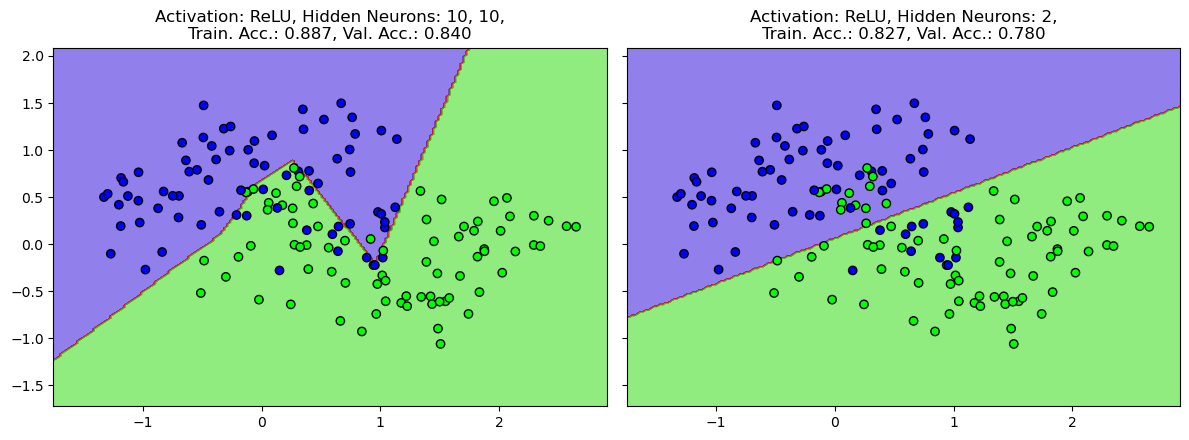

In [1]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.datasets import make_classification, make_moons
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin


class SimpleNet(torch.nn.Module):
    def __init__(self, activation=None, num_classes=10, in_features=2, hidden_layers=10):
        super(SimpleNet, self).__init__()
        
        if isinstance(hidden_layers,int):
            self.hidden_layers = [hidden_layers]
        else:
            self.hidden_layers = list(hidden_layers)
        
        self.in_features = in_features
        self.output = num_classes
        
        features = [self.in_features] + list(self.hidden_layers) + [self.output]
        layers = [torch.nn.Linear(inp, out) for inp, out in zip(features, features[1:])]
        self.fc_layers = torch.nn.ModuleList(layers)
        
        self.activation = torch.nn.Identity() if activation is None else activation

    def forward(self, x):
        for fc in self.fc_layers[:-1]:
            x = self.activation(fc(x))
        x = self.fc_layers[-1](x)

        return x

class TorchClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, torch_model, loss, optimizer_class, device, step_size=0.001, 
                 batch_size=64, epochs=20):
        super(TorchClassifier, self).__init__()
        
        self.torch_model = torch_model.to(device)
        self.loss = loss.to(device)
        self.optimizer = optimizer_class(torch_model.parameters(), lr=step_size)
        self.device = device
        self.batch_size = batch_size
        self.epochs = epochs
        
    def fit(self, X, y):
        self.torch_model.train()  # Netzwerk in Trainingsmodus
        X = torch.tensor(X, dtype=torch.float32).to(self.device)
        y = torch.tensor(y, dtype=torch.long).to(self.device)

        dataset = torch.utils.data.TensorDataset(X, y)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)     #splits up data in Mini-Batches

        for epoch in range(self.epochs):
            for batch_X, batch_y in dataloader:
                self.optimizer.zero_grad()
                output = self.torch_model(batch_X)  #Forward Pass
                loss = self.loss(output, batch_y)   #Loss calculation
                loss.backward()                     #Backpropagation --> implicitly calculates gradients
                self.optimizer.step()


    def predict(self, X):
        self.torch_model.eval()  # Netzwerk in Evaluationsmodus
        with torch.no_grad():
            X = torch.tensor(X, dtype=torch.float32).to(self.device)
            output = self.torch_model(X)
            preds = torch.argmax(output, dim=1)
            return preds.cpu().numpy()
            

# Generate toy data
n = 200
n_classes = 2
X, Y = make_moons(n, noise=0.3, random_state=123456)

#n_classes = 2
#X, Y = make_classification(n, n_features=2, n_redundant=0, n_classes=n_classes,
#                           n_clusters_per_class=2, class_sep=1.2, random_state=12345)
# You can also try a dataset with more than 2 classes
#n_classes = 3
#X, Y = make_classification(n, n_features=2, n_redundant=0, n_classes=n_classes,
#                           n_clusters_per_class=1, class_sep=1.0, random_state=5432)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=12345)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD
# Change this to 'cuda' if you can and want to use a GPU for training
# Otherwise, you can completely ignore this parameter
device = torch.device('cpu')  
batch_size=100
epochs = 500
def get_classifier(activation=None, hidden_layers=10, step_size=0.001):
    return TorchClassifier(SimpleNet(activation=activation, hidden_layers=hidden_layers, num_classes=n_classes), 
                           loss, optimizer, device, step_size=step_size, batch_size=batch_size, epochs=epochs)
classifiers = [
    # Add some instances of the neural network here, for example:
    ('Activation: ReLU, Hidden Neurons: 10, 10',
    get_classifier(torch.nn.ReLU(), [10, 10], 0.5)),
    ('Activation: ReLU, Hidden Neurons: 2',
    get_classifier(torch.nn.ReLU(), 2, 0.5))
]

# Plot decision surface
# First generate grid
res = 200  # Resolution of the grid in cells
x_max, y_max = np.max(X, axis=0)
x_min, y_min = np.min(X, axis=0)
x_min, x_max = x_min - (x_max - x_min) * 0.0625, x_max + (x_max - x_min) * 0.0625
y_min, y_max = y_min - (y_max - y_min) * 0.0625, y_max + (y_max - y_min) * 0.0625
grid_x, grid_y = np.meshgrid(np.linspace(x_min, x_max, res),
                             np.linspace(y_min, y_max, res))
# Get test array from grid
grid_input = np.c_[grid_x.reshape(-1), grid_y.reshape(-1)]

cmap = colors.ListedColormap([[0.0, 0.0, 1.0], [1.0, 0.0, 0.0], [0.0, 1.0, 0.0]])
rows = (len(classifiers)+1)//2
fig, axes = plt.subplots(rows, 2, sharex=True, sharey=True, figsize=(12, 4.5*rows))
for (name, clf), ax in zip(classifiers, axes.ravel()):
    clf.fit(X_train, Y_train)
    score = clf.score(X_test, Y_test)
    train_score = clf.score(X_train, Y_train)
    grid_out = clf.predict(grid_input).reshape(grid_x.shape)

    ax.set_title('%s,\nTrain. Acc.: %.3f, Val. Acc.: %.3f' % (name, train_score, score))
    ax.contourf(grid_x, grid_y, grid_out, alpha=0.5, cmap=plt.cm.brg)
    ax.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap=cmap, edgecolor='k')
plt.tight_layout()
plt.show()
plt.close(fig)

## 2. LeNet (MANDATORY)
The *LeNet-5* architecture, proposed in 1998 by Yann LeCun et al., was one of the first CNNs and can be seen as the predecessor and source of inspiration of most modern CNN architectures. Most beginner-level tutorials on CNNs include the implementation of a "LeNet-like" network (for example the [official PyTorch tutorials](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html)), which differs from the original in quite some ways. In this exercise, however, we would like to re-implement the LeNet-5 architecture as close to the original as it is reasonably possible in a modern framework such as PyTorch. Please read the relevant sections on LeNet-5 from the [paper](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf) by LeCun et al. and implement their architecture with two small changes:
* You don't have to reproduce the complicated connection pattern between feature maps in layer *C3*. But in order to stay faithful to the spirit of original, implement the layer such that half of the filters are connected only to the first three input feature maps and the other half to the last three.
* The output layer (called RBF layer in the paper) with fixed parameters is not too useful if you want to use the network on different datasets. Replace it by a standard fully-connected layer that has as many outputs as there are classes for the specific task.

**Hints:**
* Carefully read the documentation of the [`torch.nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) module to understand what the different parameters of a convolution layer are and what their effect is. You can also check the previous programming exercise for an introduction to convolutions.
* When you put everything together as described in the paper and the two bullet points above, your model should have seven layers and a total of 60550 trainable parameters.

In [4]:
import torch

class LeNet(torch.nn.Module):
    def __init__(self, activation=None, num_classes=10, in_channels=3):
        super(LeNet, self).__init__()
        self.activation = activation
        
        #Layer 1:
        self.conv1 = torch.nn.Conv2d(in_channels, 6, 5, padding = 2)     #input channel, output_channels (no. filters), kernel_size
        #Layer 2:
        self.average_pooling = torch.nn.AvgPool2d(kernel_size = 2, stride = 2)
        self.conv2 = torch.nn.Conv2d(6, 6, 1, groups=6)
        #Layer 3:
        self.conv3 = torch.nn.Conv2d(6, 16, 5, groups = 2)     #input channel, output_channels, kernel_size
        #Layer 4:
        self.average_pooling = torch.nn.AvgPool2d(kernel_size = 2, stride = 2)
        self.conv4 = torch.nn.Conv2d(16, 16, 1, groups=16)
        #Layer 5:
        self.layer5 = torch.nn.Linear(400, 120)
        #Layer 6:
        self.layer6 = torch.nn.Linear(120, 84)
        #Output Layer:
        self.out = torch.nn.Linear(84, num_classes)

    def forward(self, x):
        l1 = self.activation(self.conv1(x))

        l2 = self.average_pooling(l1)
        l2 = self.activation(self.conv2(l2))

        l3 = self.activation(self.conv3(l2))

        l4 = self.average_pooling(l3)
        l4 = self.activation(self.conv4(l4))

        l4 = l4.reshape(-1, 16*5*5)

        l5 = self.activation(self.layer5(l4))

        l6 = self.activation(self.layer6(l5))

        out = self.out(l6)

        return out

# Choose the activation function from the paper
activation = lambda x: 1.7159*torch.tanh(0.6667*x)
network = LeNet(activation=activation, in_channels=1)
print('Network parameters:', sum(p.numel() for p in network.parameters()))

Network parameters: 60550


## 3. ANN Training (MANDATORY)
In this exercise, we want to use the CNN from part 2 on the so called "[Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist)" dataset. It comes with a training set that contains 60000 gray-scale images of size 28 by 28 pixels and a test set with 10000 images of the same dimensions. Each image belongs to exactly one of the ten classes and each class corresponds to a different piece of clothing (hence the name). Fashion MNIST is intended as a replacement for the original MNIST dataset which contained images of handwritten digits from 0 to 9 with the same dimensionality. As you have probably read in the paper by LeCun et al., the LeNet-5 architecture was originally used for recognizing such handwritten digits.

You don't need to download the dataset manually, since this functionality is already included in the `torchvision` package, please take a look at [`torchvision.datasets.FashionMNIST`](https://pytorch.org/vision/stable/datasets.html#fashion-mnist). However, this class won't load all the images into memory on its own, instead data is only streamed from disk at the moment where you access it. Note that this is actually desired behaviour, since some datasets might not even fit in your main memory, so you would ideally only keep the mini-batch that you are currently processing in memory. This kind of functionailty is implemented in the [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) class. It creates an iterator which loops over a shuffled version of the given dataset and returns a `(batch_X, batch_y)` tuple with each iteration. One pass through the iterator corresponds to one epoch of training.

1. Training a neural network can take a considerable amount of time, so it is important to keep track of what is going on during training. For that, write a new training function that trains a neural network using a `DataLoader` as described above. As mentioned in ex. 1, training should be done via mini-batch stochastic gradient descent; see [`torch.optim.SGD`](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD) for an implementation that you can use. However, instead of sampling a random mini-batch before each update step, it is much more common in neural network training to randomly shuffle the entire dataset before the actual training loop and then partition the shuffled data deterministically into mini-batches from start to end. One pass through the entire dataset is called an *epoch* and training is usually not limited by a fixed amount of gradient descent updates but by the number of epochs to perform instead. Note that the step size of the (stochastic) gradient descent algorithm is often called *learning rate* in the context of neural network training. Most of that functionality is already included in the `DataLoader` or `torch.optim.SGD` classes, please consult their documentation for more details.

   Before training, the dataset is usually split into a training and test dataset, or -- like it is the case for FashionMNIST -- the dataset already contains distinct training and test samples. Report the average loss and accuracy (fraction of correctly classified inputs) on the training dataset during each epoch and also compute average loss and accuracy on the test set after each epoch. Your function should return a collection of those values, so that they can be visualized later.

   **Tip:** The `tqdm` package makes it easy to create good-looking progress bars that you can customize with your own texts. To make it work in a Jupyter notebook, you should use the classes from the [`tqdm.notebook`](https://tqdm.github.io/docs/notebook/) module.


2. Train the LeNet network from ex. 2 on the Fashion MNIST dataset for 15 epochs using the function from part 1 with the following parameters:
   * batch size: 64
   * step_size: 0.01
   * 2-norm regularization coefficient (also called "weight decay"): 0.0004 
   * loss function: [`torch.nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) (see ex. 1 for details)
   
   Your Network should reach at least 86% accuracy on the test set in one of the 15 epochs.
   
   Then use the data returned by the training function to visualize the training procedure. More specifically, create two plots: One should show the average loss on the y-axis and the epoch on the x-axis. Plot the values for training and testing set in the same figure, so that you can easily compare them. You should do the same for the accuracy in each epoch, but in a separate plot.

   **Tip:** Take a look at the [`torch.save`](https://pytorch.org/docs/stable/generated/torch.save.html) function which allows you to save your model after or during training. It might become annoying to re-train the model each time you change a line of code, so you can train it just once and then simply load it from disk afterwards.


3. Given a dataset $D = \{(\mathbf{x}^{(1)}, y^{(1)}), (\mathbf{x}^{(2)}, y^{(2)}), \ldots, (\mathbf{x}^{(n)}, y^{(n)})\} \subseteq \mathcal{X} \times \{1, \ldots, k\}$ and a classifier $f: \mathcal{X} \to \{1, \ldots, k\}$, we define the confusion matrix $C_f$ in the following way:
\begin{equation*}
    C_{ij} := \frac{\lvert \left\{ (\mathbf{x}, y) \in D \mid y=i \land f(\mathbf{x})=j \right\} \rvert}{\lvert \left\{ (\mathbf{x}, y) \in D \mid y=i \right\} \rvert},
\end{equation*}
i.e., $C_{ij}$ is defined as the fraction of data points from $D$ that belong to class $i$ and are classified as $j$ by $f$. Such a matrix offers more information than a simple scalar like accuracy or loss, since it becomes obvious where exactly the classifier makes its mistakes.
  
   After training the LeNet on the Fashion MNIST training dataset, compute, show and interpret the confusion matrix of that classifier on the Fashion MNIST test dataset. You can also compute the confusion matrix after each epoch of training to see how it develops. A mapping from numeric class labels to semantically meaningful class names is available on the [Fashion MNIST website](https://github.com/zalandoresearch/fashion-mnist#labels).
   

4. **(OPTIONAL)** Start experimenting with hyperparameters such as learning rate, batch size, and/or optimization algorithm. Can you improve the test set accuracy compared to the original set of parameters?

Epoch  0  finished.
Epoch  1  finished.
Epoch  2  finished.
Epoch  3  finished.
Epoch  4  finished.
Epoch  5  finished.
Epoch  6  finished.
Epoch  7  finished.
Epoch  8  finished.
Epoch  9  finished.
Epoch  10  finished.
Epoch  11  finished.
Epoch  12  finished.
Epoch  13  finished.
Epoch  14  finished.


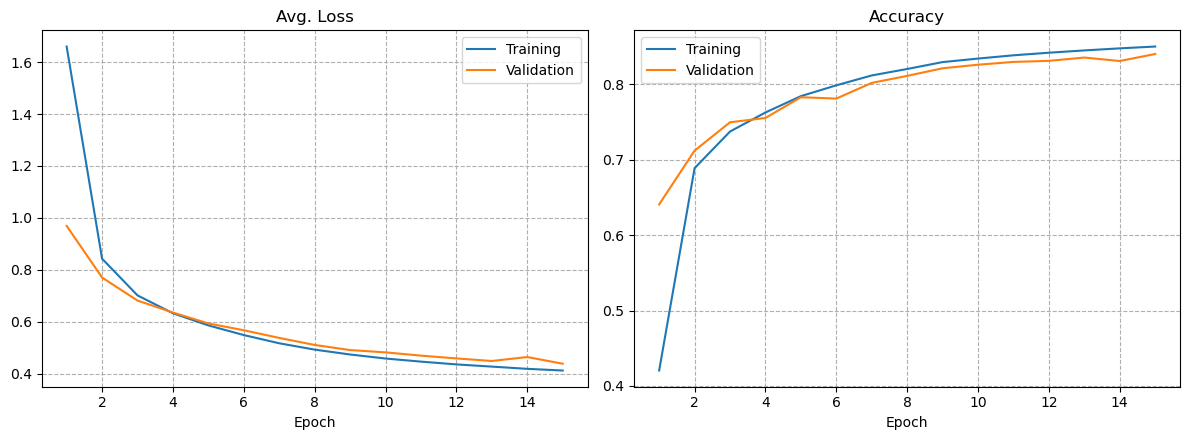

In [7]:
%matplotlib inline
import os
import torch
import torchvision
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


def train_model(network, loss, optimizer, train_iter, val_iter, num_epochs, device='cpu', start_epoch=0,
                checkpoints=False, out_dir=None):
    """
    Train a PyTorch neural network with the specified parameters
    
    :param network: The neural network to train. Should be a subclass of :class:`torch.nn.Module`
    :param loss: The loss function to use. Should take arguments of the form (prediction, true_value)
    :param optimizer: The optimization algorithm that is used for training. Should be a subclass of :class:`torch.optim.Optimizer`
    :param train_iter: A :class:`torch.utils.data.Dataloader` instance that yields mini-batches for training
    :param val_iter: A :class:`torch.utils.data.Dataloader` instance that yields mini-batches for testing
    :param num_epochs: The number of epochs to train the network for
    :param device: The device to use for training. Usually 'cpu' or 'cuda'
    :param start_epoch: The first epoch to start with. This is for the case of resuming training from a checkpoint
    :param checkpoints: Whether to save a checkpoint of the model after each training epoch
    :param out_dir: Directory where the checkpoints will be saved
    
    :returns: The avg. training and test loss and accuracy for each epoch
    """
    avg_training_loss = []
    train_accs = []
    avg_val_loss = []
    val_accs = []
    for i in range(start_epoch, start_epoch + num_epochs):
        network.train()
        epoch_loss = []
        correct_train = 0
        total_train = 0
        for (X_batch, y_batch) in train_iter:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            result = network(X_batch)
            l = loss(result, y_batch)
            l.backward()
            optimizer.step()
            epoch_loss.append(l.item())

            preds = torch.argmax(result, dim=1)
            correct_train += (preds == y_batch).sum().item()
            total_train += y_batch.size(0)

        avg_training_loss.append(sum(epoch_loss)/len(epoch_loss))
        train_accs.append(correct_train / total_train)

        # Validation
        network.eval()
        val_loss = []
        with torch.no_grad():
            correct_val = 0
            total_val = 0
            for (X_val, y_val) in val_iter:
                X_val, y_val = X_val.to(device), y_val.to(device)
                result = network(X_val)
                l = loss(result, y_val)
                val_loss.append(l.item())

                preds = torch.argmax(result, dim=1)
                correct_val += (preds == y_val).sum().item()
                total_val += y_val.size(0)

        avg_val_loss.append(sum(val_loss) / len(val_loss))
        val_accs.append(correct_val / total_val)
        print("Epoch ", i, " finished.")
    
    return dict(train_loss=avg_training_loss, train_acc=train_accs, val_loss=avg_val_loss, val_acc=val_accs)



def plot_history(history):
    # Plot training and validation curves for avg. loss and accuracy
    fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))
    data = [('Avg. Loss', history['train_loss'], history['val_loss']), 
            ('Accuracy', history['train_acc'], history['val_acc'])]
    for ax, (name, train_hist, val_hist) in zip(axes, data):
        ax.set_title(name)
        ax.set_xlabel('Epoch')
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        ax.grid(linestyle='dashed')
        ax.plot(range(1, len(train_hist)+1), train_hist, label='Training')
        ax.plot(range(1, len(val_hist)+1), val_hist, label='Validation')
        ax.legend()
    
    plt.tight_layout()
    plt.show()
    plt.close(fig)
    
def confusion_matrix(network, val_iter, num_classes=10, device='cpu'):
    matrix = torch.zeros(size=(num_classes, num_classes), dtype=torch.get_default_dtype(),
                        device='cpu')
    
    network.eval()
    for batch_x, batch_y in val_iter:
        batch_x = batch_x.to(device)
        res = network(batch_x)
        res = torch.argmax(res, dim=-1).data.cpu()
        
        indices = torch.stack([batch_y, res], dim=1)
        indices, counts = torch.unique(indices, dim=0, return_counts=True)
        matrix[indices[:,0], indices[:,1]] += counts
    
    matrix /= torch.sum(matrix, dim=1, keepdims=True)
    
    return matrix


# Change this to 'cuda' if you can and want to use a GPU for training
# Otherwise, you can completely ignore this parameter
device = torch.device('cpu')
dataset = torchvision.datasets.FashionMNIST
batch_size = 64
num_epochs = 15
num_workers = 0  # You can use multiple processes to load the data. 0 means that everything is done in the same process
step_size = 1e-2
regularization=0.0004  # Contols how much the Frobenius norm of the parameters contributes to the final loss
checkpoints = True  # Save the model after each epoch of training
out_dir = 'models'  # Folder, where your model checkpoints will be saved
load_path = None    # Don't train the model, but load it from the specified file instead
data_dir = 'data'   # Folder that contains the dataset. If it is not present, 
                    # the dataset will be downloaded into that folder

is_cuda = device.type == 'cuda'
train_dataset = dataset(data_dir, download=True, train=True, transform=torchvision.transforms.ToTensor())
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                    num_workers=0, pin_memory=is_cuda)
val_dataset = dataset(data_dir, download=True, train=False, transform=torchvision.transforms.ToTensor())
val_iter = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True,
                                    num_workers=0, pin_memory=is_cuda)
# Instantiate the network, optimizer, etc.
activation=lambda x: 1.7159*torch.tanh(0.6667*x)
network = LeNet(activation=activation, in_channels=1)
network = network.to(device)
loss = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(network.parameters(), lr=step_size, weight_decay=regularization)
start_epoch = 0

if load_path is not None:
    # TODO: Load model, optimizer state and history 
    pass
else:
    history = train_model(network, loss, optimizer, train_iter, val_iter, num_epochs, device,
                      start_epoch, checkpoints=checkpoints, out_dir=out_dir)
    

# TODO: Plot the training history
plot_history(history)

# TODO: And finally compute the confusion matrix
mat = confusion_matrix(network, val_iter, device=device)
print('Confusion matrix:', mat)